In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

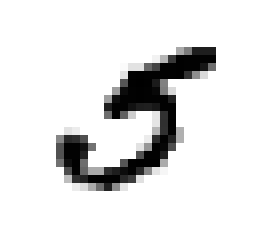

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
interpolation="nearest")
plt.axis("off")
plt.show()

In [4]:
y[36000]

5.0

In [5]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [6]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [8]:
sgd_clf.predict([X[36000]])

array([False], dtype=bool)

In [9]:
[y[36000]]

[5.0]

# cross_val_score() implementation 

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495

0.96615
0.9643
0.96065


In [11]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(scores)

[ 0.96615  0.9643   0.96065]


In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.90985,  0.90785,  0.91125])

# Confusion and scores

In [14]:
from sklearn.metrics import confusion_matrix
y_train_pred = sgd_clf.predict(X_train)
confusion_matrix(y_train_5, y_train_pred)

array([[54246,   333],
       [ 1953,  3468]])

In [15]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

0.912391475927
0.639734366353
0.752114508783


## Tradeoff between recall and prediction

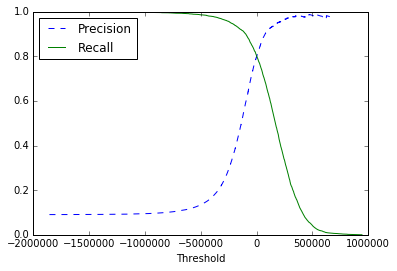

In [17]:
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

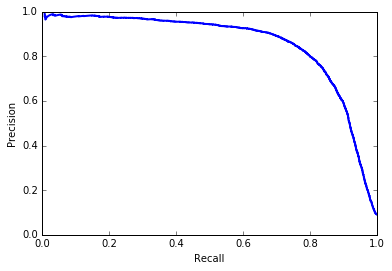

In [18]:
def plot_PR_curve(precisions, recalls, label=None):
    plt.plot(recalls, precisions, linewidth=2, label=label)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
plot_PR_curve(precisions, recalls)
plt.show()

## Receiver Operating Shcracteristics

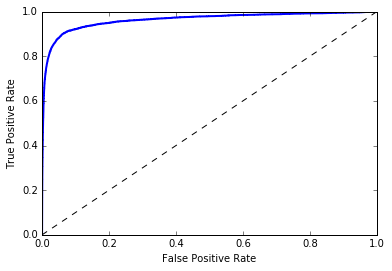

In [19]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [20]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train_5, y_scores))

0.963218982928


comparison with random forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [22]:
y_scores_forest = y_probas_forest[:, 1] #
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

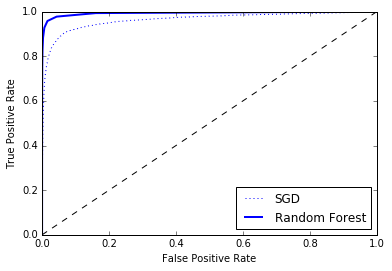

In [23]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [24]:
roc_auc_score(y_train_5, y_scores_forest)

0.99312720945695454

# Multiclass Classification

In [25]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [26]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [27]:
sgd_clf.predict([X_train[3000]])

array([ 3.])

In [28]:
sgd_clf.decision_function([X_train[3000]])

array([[-732036.12392699, -456759.87731476, -134122.92357288,
         129843.06722257, -516286.05017962, -157946.80958645,
        -734548.86193745, -291568.48782272, -203677.27007465,
        -576753.63786281]])

In [29]:
from sklearn.multiclass import OneVsOneClassifier
ovo_sgd_clf = OneVsOneClassifier(SGDClassifier(random_state=42))

In [30]:
ovo_sgd_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False),
          n_jobs=1)

In [31]:
ovo_sgd_clf.predict([X_train[3000]])

array([ 3.])

In [32]:
ovo_sgd_clf.decision_function([X_train[3000]])

array([[ 0.63156695,  4.93398885,  7.21943203,  9.46452362,  1.71002677,
         6.10566894, -0.5       ,  2.93834932,  7.40799643,  5.08844708]])

In [33]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [34]:
forest_clf.predict([X_train[3000]])

array([ 3.])

In [35]:
forest_clf.predict_proba([X_train[3000]])

array([[ 0. ,  0. ,  0. ,  0.9,  0. ,  0. ,  0. ,  0. ,  0.1,  0. ]])

In [36]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.86902619,  0.86764338,  0.85762864])

In [37]:
cross_val_score(ovo_sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.90746851,  0.90309515,  0.90328549])

Scalling can greatly improve scores

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

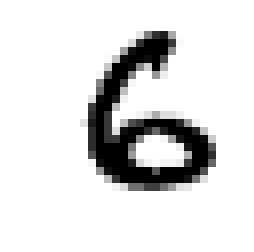

In [39]:
some_digit = X_train[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
interpolation="nearest")
plt.axis("off")
plt.show()

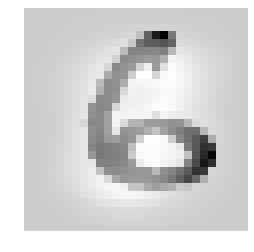

In [40]:
some_digit = X_train_scaled[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
interpolation="nearest")
plt.axis("off")
plt.show()

In [ ]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [ ]:
cross_val_score(ovo_sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# Exercises
## 1. 97% accuracy on NIST - Using KNeighborsClassifier

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier(n_jobs=-1, n_neighbors =5)
knn_clf.fit(X_train, y_train)
y_knn_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_knn_pred)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [48]:
cross_val_score(knn_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.94726055,  0.9480974 ,  0.94389158])

In [49]:
cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.97130574,  0.97164858,  0.97184578])

In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': [4, 5, 10, 15]},
]

grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring="accuracy")

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': [4, 5, 10, 15]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [44]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [47]:
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier(n_jobs=-1, n_neighbors =4, weights='distance')
knn_clf.fit(X_train, y_train)
y_knn_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_knn_pred)

0.97140000000000004

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

knn_clf = KNeighborsClassifier(n_jobs=-1, n_neighbors =4, weights='distance')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
knn_clf.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test.astype(np.float64))
y_knn_pred = knn_clf.predict(X_test_scaled)
accuracy_score(y_test, y_knn_pred)

0.94889999999999997

## 2. Shifting NNIST images by one pixel to expand training set

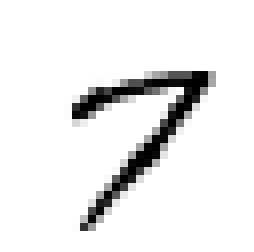

In [58]:
from scipy.ndimage.interpolation import shift

some_digit_image = X_train[6000]
some_digit_image = some_digit_image.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
interpolation="nearest")
plt.axis("off")
plt.show()

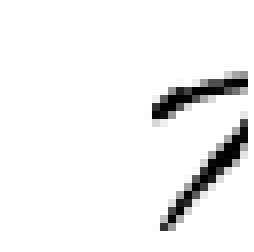

In [67]:
def shift_img(digit_array, dx, dy):
    from scipy.ndimage.interpolation import shift
    return shift(digit_array.reshape(28,28), (dx, dy)).reshape(784)

new_image = shift_img(some_digit_image, 0, 10).reshape(28,28)
plt.imshow(new_image, cmap = matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

In [74]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    chunck = np.apply_along_axis(shift_img, 1, X_train, dx, dy )
    X_train_expanded.append(chunck)
    y_train_expanded.append(y_train)
    
X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)

In [75]:
X_train_expanded.shape

(300000, 784)

In [76]:
knn_clf = KNeighborsClassifier(n_jobs=-1, n_neighbors =4, weights='distance')
knn_clf.fit(X_train_expanded, y_train_expanded)
y_knn_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_knn_pred)

0.97629999999999995

## 3. Titanic dataset